### Annotate growth cones in timelapse sequences

This second notebook for training data creation facilitates axon growth cone
labeling using the napari ImageViewer. Label layers are added from this
notebook, then axon labels are manually assigned. In an iterative process this
yields growth cone label CSV files for all timelapses. 

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import napari

In [2]:
def timelapse2gui(basename, viewer):
    """
    Load a timelapse into the GUI (napari) using it's basename.
    
    Arguments
    ---------
        basename: str
            The base filename of the timelapse.
        viewer: napari.ImageViewer
            The GUI instance.
    """
    signal = load_timelapse(basename, postfix='', plot_distr=True)
    viewer.add_image(signal, contrast_limits=(0,2**10))

In [3]:
def add_empty_labels(indices):
    """
    Add a collection of empty points-layers in napari representing axon
    identities/ labels. If the points-layer /axon ID already exists it won't 
    be added to the viewer.
    
    Arguments
    ---------
        indices: [int, int, ...]
            The IDs to add. Should be between 0 and 999.
    """
    print(f'\nCreating empty axon labels: {indices}')
    for ax_i in indices:
        name = f'Axon_{ax_i:0>3}'
        if name in viewer.layers:
            print(f'Cannot add {name} - Point layer already exists!')
        else:
            col = np.random.rand(1,3)
            viewer.add_points(name=name, edge_color=col, face_color=col, 
                              opacity=.25, size=35, ndim=3)

In [4]:
def axon_labels2dataframe(indices):
    """
    Convert a set of axon labels identified by passed indices from points-layers
    in the GUI to a pd.DataFrame. Returns the DataFrame with rows represeting
    timepoints/ corresponding frames and columns referring to axon IDs plus X,Y
    coordinates. 
    
    Arguments
    ---------
        indices: [int, int, ...]
            The axon IDs to convert. If these indices are not found as
            points-layers, they won't be added to the DataFrame. Also, if the
            points-layer is empty (no-label), timepoints contain more than one
            xy-coordinate (duplicate-label) or the label-timpoints are not
            continuous (label-gaps) the ID won't be added to the DataFrame. All
            these instances of invalid labeling are printed out. Note that
            DataFrames with discontinuous IDs (due to errors mentioned before)
            will not save to csv using the `save_axon_ID_data` function.
    Returns
    -------
        all_axons_data: pd.DataFrame of shape [ntimpoints, nIDs*2]
            DataFrame with rows represeting timepoints/ corresponding frames and
            columns referring to axon IDs with X,Y coordinates.
    """
    print(f'\nSaving axon labels: {indices}')

    all_axons_data = []
    for ax_i in indices:
        name = f'Axon_{ax_i:0>3}'
        idx = pd.MultiIndex.from_product([(name,), ('anchor_y', 'anchor_x')])
        dat = viewer.layers[name].data
        data = pd.DataFrame(dat[:,1:], index=(dat[:,0]).astype(int), 
                            columns=idx, dtype=int)

        if data.empty:
            print(f'{name} - point layer was empty! - Skipping.')
            continue
        
        double_lbl = data.index[data.index.duplicated()]
        if double_lbl.any():
            print(f'{name} - point layer has timepoints with more than '
                  f'one anchor, t: {double_lbl.values} - Skipping.')
            continue
        
        cont = data.shape[0] == len(range(data.index.min(), data.index.max()+1))
        if not cont:
            print(f'{name} - Not a continuous series of labels! Check '
                  f'timepoints: {data.index.values} - Skipping.')
            continue
        
        print(f'{name} - all good.')
        all_axons_data.append(data)
    all_axons_data = pd.concat(all_axons_data, axis=1)
    return all_axons_data

In [5]:
def save_axonID_data(axonIDs_data, basename):
    """
    Save a set of axon labels in a pd.DataFrame to a csv. IDs in the DataFrame
    must be continuous (no gaps) and there cannot be an existing CSV file with
    overlapping IDs. The CSV will be saved as
    {data_path}/all_labels_csvs/{basname}_labels_{firstID}_{lastID}.csv. The
    final label file will be constructed from the set of all these CSV files.
    
    Arguments
    ---------
        axonID_data: pd.DataFrame of shape [ntimpoints, nIDs*2]
            DataFrame with rows represeting timepoints/ corresponding frames and
            columns referring to axon IDs with X,Y coordinates.
    """
    # get the IDs to add from string Axon_042 to int 42
    IDs_to_add = [int(ID[-3:]) for ID in axonIDs_data.columns.unique(0)]
    cont_IDs = len(IDs_to_add) == len(range(min(IDs_to_add), max(IDs_to_add)+1))
    
    # get all the existing files and infer the already labelled IDs from range
    existing_IDs_files = glob.glob(f'{data_path}/all_labels_csvs/{basename}*.csv')
    existing_IDs_str = [fname[fname.rfind('_')+1:-4].split('-') 
                        for fname in existing_IDs_files]
    existing_IDs = [i for start, stop in existing_IDs_str 
                    for i in range(int(start), int(stop))]
    
    print(f'\nTrying to save axon IDs: {IDs_to_add}\n'
          f'Existing IDs ranges: {existing_IDs_str}, full list: {existing_IDs}')
    
    dupl_ID = [i for i in IDs_to_add if i in existing_IDs]
    if dupl_ID:
        print(f'Indices countains IDs that already exists for {basename}: '
              f'{dupl_ID}. Won\'t save.')
        return
    
    if not cont_IDs:
        print(f'Axon IDs for  {basename} are not continuous. Fix the gaps:'
              f'{IDs_to_add}. Won\'t save.')
        return
    
    # last axon id is INCLUDED
    name = f'{basename}_labels_IDs_{IDs_to_add[0]:0>3}-{IDs_to_add[-1]:0>3}'
    fname = f'{data_path}/all_labels_csvs/{name}.csv'
    print(f'Saving IDs: {fname}')
    axonIDs_data.to_csv(fname)

In [6]:
def merge_axonID_files(basename):
    """
    Merge the set of all CSV label files matching the passed basename. Returns a
    pd.DataFrame of shape [ntimpoints, nIDs*2]. DataFrame with rows represeting
    timepoints/ corresponding frames and columns referring to axon IDs with X,Y
    coordinates.
    
    Arguments
    ---------
        str: basename
            The basename to identify labels in the all_labels_csvs directory.
    Returns
    -------
        axonIDs: pd.DataFrame of shape [ntimpoints, nIDs*2]
            DataFrame with rows represeting timepoints/ corresponding frames and
            columns referring to axon IDs with X,Y coordinates.
    """
    existing_IDs_files = glob.glob(f'{data_path}/all_labels_csvs/{basename}*.csv')
    print(f'Loading labels for {basename}. Found the following files: '
          f'{existing_IDs_files}')
    axonIDs = [pd.read_csv(fname, header=[0,1], index_col=0) 
               for fname in existing_IDs_files]
    axonIDs = pd.concat(axonIDs, axis=1)
    print(axonIDs)
    return axonIDs

In [7]:
def axonIDs2gui(axonIDs, viewer):
    """
    Load the axon IDs from a pd.DataFrame into the viewer.
    
    Arguments
    ---------
        axonIDs: pd.DataFrame of shape [ntimpoints, nIDs*2]
            The DataFrame with the labels to load. If the ID exist already
            as a points-layer it won't be added to the viewer.
    """
    print('Adding', end=' ')
    for axonID in axonIDs.columns.unique(0):
        print(axonID, end='...')
        if axonID not in viewer.layers:
            dat = axonIDs.loc[:, (axonID, ['anchor_y','anchor_x'])].reset_index().dropna()
            col = np.random.rand(1,3)
            viewer.add_points(name=axonID, edge_color=col, face_color=col, 
                              opacity=.25, size=35, ndim=3)
            viewer.layers[axonID].data = dat.values.astype(int)
        else:
            print('exists already, skipping', end='...')

In [8]:
if (__name__ == '__main__' and '__file__' not in globals()):
    plt.style.use('dark_background')
    %run '01_process_training_timelapses.ipynb'
else:
    raise SystemExit("Function `load_axonIDs` `timelapse2gui` loaded successfully.")

Loaded functions `load_timelapse`, `load_mask` successfully.


In [9]:
# create the GUI object for labelling
viewer = napari.Viewer()

### Set the names of the files to label. Once done with a timelapse sequence update the index and move on to the next video sequence.



=== `D00_G001` tif loaded ===
TxHxW: 37x2080x5764
dtype: uint16
min:0, max:4095
Frame wise min: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


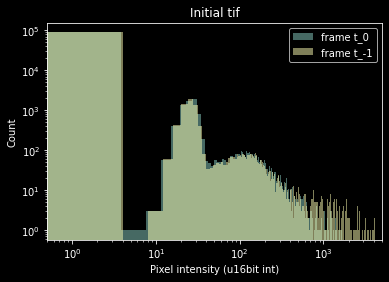

In [10]:
data_path = '/run/media/loaloa/lbbSSD/training_data/'
tlapse_names = ['D00_G001', 'D04_G004', 'D19_G035']

# which dataset to label
index = 0
basename = tlapse_names[index]
# load the video into the gui
timelapse2gui(basename, viewer)

### Labelling workflow: 
1. Add empty labels layers and annotate growth cones through time.
2. Convert the points-layers in napari to a DataFrame. Check label validity,
   then save this set of labels to a CSV
3. When all valid, remove the points-layers from the GUI and return to 1.
4. When all growth cones are labelled, do a test merge and load them into the GUI
to confirm validity.

In [13]:
# Step 1
indices = range(20)
add_empty_labels(indices)
# Have fun labelling:)


Creating empty axon labels: range(0, 20)


In [ ]:
# Step 2
axonIDs_data = axon_labels2dataframe(indices)
save_axonID_data(axonIDs_data, basename)

In [ ]:
# step 4
axonIDs_data = merge_axonID_files(basename)
axonIDs2gui(axonIDs_data, viewer)